##Loading libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import nltk
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from joblib import dump

##Loading Data

In [2]:
data=pd.read_csv('airline_sentiment_analysis.csv',index_col=False)
data.head()

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [3]:
data.shape

(11541, 3)

In [4]:
data.drop(data.columns[0], axis = 1, inplace=True)

In [5]:
data.head()

,airline_sentiment,text
0,positive,@VirginAmerica plus you've added commercials t...
1,negative,@VirginAmerica it's really aggressive to blast...
2,negative,@VirginAmerica and it's a really big bad thing...
3,negative,@VirginAmerica seriously would pay $30 a fligh...
4,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  11541 non-null  object
 1   text               11541 non-null  object
dtypes: object(2)
memory usage: 180.5+ KB


In [7]:
data['airline_sentiment'] = data['airline_sentiment'].astype('str')

In [8]:
data['text'] = data['text'].astype('str')

In [9]:
data.dtypes

airline_sentiment    object
text                 object
dtype: object

In [10]:
data["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

##Data Preprocessing

In [11]:
data.iloc[0,1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

In [12]:
data.iloc[1403,1]

'@united Are your earnings so low that checkin people have to also be on Tarmac loading bags? JAN'

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [15]:
stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [16]:
def data_cleaner(data):
    clean_data = []
    for sentence in tqdm(data):
        cleantext = BeautifulSoup(sentence, "lxml").text #html tags
        # cleantext = cleantext.replace('http\S+|www.\S+', '', case=False)#Remove URLs
        cleantext = re.sub(r'[^\w\s]','',cleantext) # punctuation
        # cleantext = cleantext.replace('\d+', '')
        cleantext = [token for token in cleantext.lower().split() if token not in stopword] #stopword
        clean_text = ' '.join([lemmatizer.lemmatize(token) for token in cleantext])
        clean_data.append(clean_text.strip())
    return clean_data

In [17]:
data['text'] = data['text'].str.replace('http\S+|www.\S+', '', case=False)#Remove URLs
data['text'] = data['text'].str.replace('\d+', '')

<ipython-input-17-f259204d005c>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace('http\S+|www.\S+', '', case=False)#Remove URLs
<ipython-input-17-f259204d005c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace('\d+', '')


In [18]:
clean_data = data_cleaner(data.text.values)

100%|██████████| 11541/11541 [00:05<00:00, 2225.38it/s]


In [19]:
clean_data[130]

'virginamerica never recd cancelled flightlation notice left w option fly p driving la red eye mon w kid'

##Train Test Split

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data.airline_sentiment, test_size=0.2, random_state=42 ,stratify=data["airline_sentiment"])

In [21]:
data.head()

,airline_sentiment,text
0,positive,@VirginAmerica plus you've added commercials t...
1,negative,@VirginAmerica it's really aggressive to blast...
2,negative,@VirginAmerica and it's a really big bad thing...
3,negative,@VirginAmerica seriously would pay $ a flight ...
4,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [22]:
X_train.head()

,airline_sentiment,text
6356,negative,@JetBlue Finally starting to come out. minute...
6807,negative,@USAirways oh I got right through to an agent....
9347,negative,@AmericanAir any idea on what the wait time is...
10375,negative,@AmericanAir Priority baggage evidently means ...
7343,negative,@USAirways you're really fudgin up with all th...


In [23]:
y_train

6356     negative
6807     negative
9347     negative
10375    negative
7343     negative
           ...   
11540    negative
7701     negative
7489     negative
1198     negative
8667     negative
Name: airline_sentiment, Length: 9232, dtype: object

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [26]:
le1 = LabelEncoder()
y_test = le1.fit_transform(y_test)

In [27]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(9232, 2) (9232,)
(2309, 2) (2309,)


In [28]:
clean_data_train_data = data_cleaner(X_train.text.values)

100%|██████████| 9232/9232 [00:02<00:00, 3458.91it/s]


In [29]:
X_train = X_train.reset_index(drop=True)
X_train['cleaned_text'] = clean_data_train_data
X_train.head()

,airline_sentiment,text,cleaned_text
0,negative,@JetBlue Finally starting to come out. minute...,jetblue finally starting come minute communica...
1,negative,@USAirways oh I got right through to an agent....,usairways oh got right agent kept putting hold...
2,negative,@AmericanAir any idea on what the wait time is...,americanair idea wait time refund usairways to...
3,negative,@AmericanAir Priority baggage evidently means ...,americanair priority baggage evidently mean co...
4,negative,@USAirways you're really fudgin up with all th...,usairways youre really fudgin delay justwantmybed


In [30]:
X_train.shape

(9232, 3)

In [31]:
X_train.iloc[0]

airline_sentiment                                             negative
text                 @JetBlue Finally starting to come out.  minute...
cleaned_text         jetblue finally starting come minute communica...
Name: 0, dtype: object

In [32]:
clean_data_test_data =  data_cleaner(X_test.text.values)

100%|██████████| 2309/2309 [00:00<00:00, 3474.33it/s]


In [33]:
X_test = X_test.reset_index(drop=True)
X_test['cleaned_text'] = clean_data_test_data
X_test.head()

,airline_sentiment,text,cleaned_text
0,negative,@USAirways your agent did not say,usairways agent say
1,negative,@united overbooked by FIFTY people?!? the worst.,united overbooked fifty people worst
2,negative,@united … But friendly efficient air attendant...,united friendly efficient air attendant coach ua
3,negative,@united considering I'm now stuck in Newark wi...,united considering im stuck newark virtually s...
4,negative,@USAirways this has been the worst trip with l...,usairways worst trip little customer service


##Vectorization

In [34]:
vec = CountVectorizer()
vec.fit(X_train.cleaned_text)
train_x_bow = vec.transform(X_train.cleaned_text)
test_x_bow = vec.transform(X_test.cleaned_text)

In [35]:
print(train_x_bow.shape)
print(test_x_bow.shape)

(9232, 9328)
(2309, 9328)


##Naive Bayes using Hyperparameter tuning

In [36]:
classfier = MultinomialNB()

In [37]:
alpha_ranges = {"alpha":[10**-2,10**-1,10**0,10**1,10**2]}
grid_search =GridSearchCV(classfier , param_grid = alpha_ranges ,scoring= "accuracy",cv=3,return_train_score = True)
grid_search.fit(train_x_bow,y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='accuracy')

In [38]:
alpha = [10**-2,10**-1,10**0,10**1,10**2]
train_acc = grid_search.cv_results_['mean_train_score']
train_std = grid_search.cv_results_['std_train_score']
test_acc = grid_search.cv_results_['mean_test_score']
test_std = grid_search.cv_results_['std_test_score']

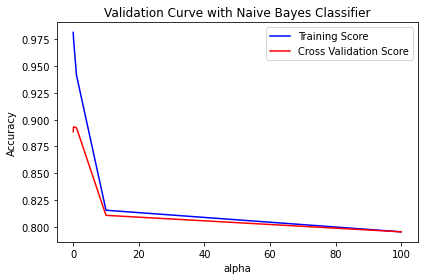

In [39]:
plt.plot(alpha, train_acc,
     label = "Training Score", color = 'b')
plt.plot(alpha, test_acc,
   label = "Cross Validation Score", color = 'r')
 
# Creating the plot
plt.title("Validation Curve with Naive Bayes Classifier")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [40]:
grid_search.best_estimator_

MultinomialNB(alpha=0.1)

In [41]:
classifier = MultinomialNB(alpha=1)
classifier.fit(train_x_bow,y_train)

MultinomialNB(alpha=1)

In [42]:
predict = classifier.predict(test_x_bow)

In [43]:
print("accuracy is :",accuracy_score(y_test,predict))

accuracy is : 0.9008228670420095


In [44]:
print("accuracy is :",classification_report(y_test,predict))

accuracy is :               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1836
           1       0.86      0.62      0.72       473

    accuracy                           0.90      2309
   macro avg       0.88      0.79      0.83      2309
weighted avg       0.90      0.90      0.89      2309



In [45]:
dump(vec,"vectors.joblib")
dump(classifier,"model.joblib")

['model.joblib']